# Age and Gender Detection form Image using CNN

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model, load_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Loading Dataset - UTKFace

In [2]:
filePath = "UTKFace"
files = os.listdir(filePath)

## Pre-Processing

In [24]:
# Extracting ages and genders
ageFiles = [int(file.split('_')[0]) for file in files]
genderFiles = [int(file.split('_')[1]) for file in files]
cnn_data = {'Age': ageFiles, 'Gender': genderFiles, 'ImageName': [file for file in files]}
cnn_df = pd.DataFrame(cnn_data)

In [25]:
cnn_df.head()

,Age,Gender,ImageName
0,100,0,100_0_0_20170112213500903.jpg.chip.jpg
1,100,0,100_0_0_20170112215240346.jpg.chip.jpg
2,100,1,100_1_0_20170110183726390.jpg.chip.jpg
3,100,1,100_1_0_20170112213001988.jpg.chip.jpg
4,100,1,100_1_0_20170112213303693.jpg.chip.jpg


In [26]:
cnn_df.shape

(23708, 3)

In [27]:
cnn_df.describe()

,Age,Gender
count,23708.000000,23708.000000
mean,33.303484,0.477349
std,19.886112,0.499497
min,1.000000,0.000000
25%,23.000000,0.000000
50%,29.000000,0.000000
75%,45.000000,1.000000
max,116.000000,1.000000


## Data Visualisation

### Distribution of Age and Gender using Distplot and Bar PLot from Seaborn

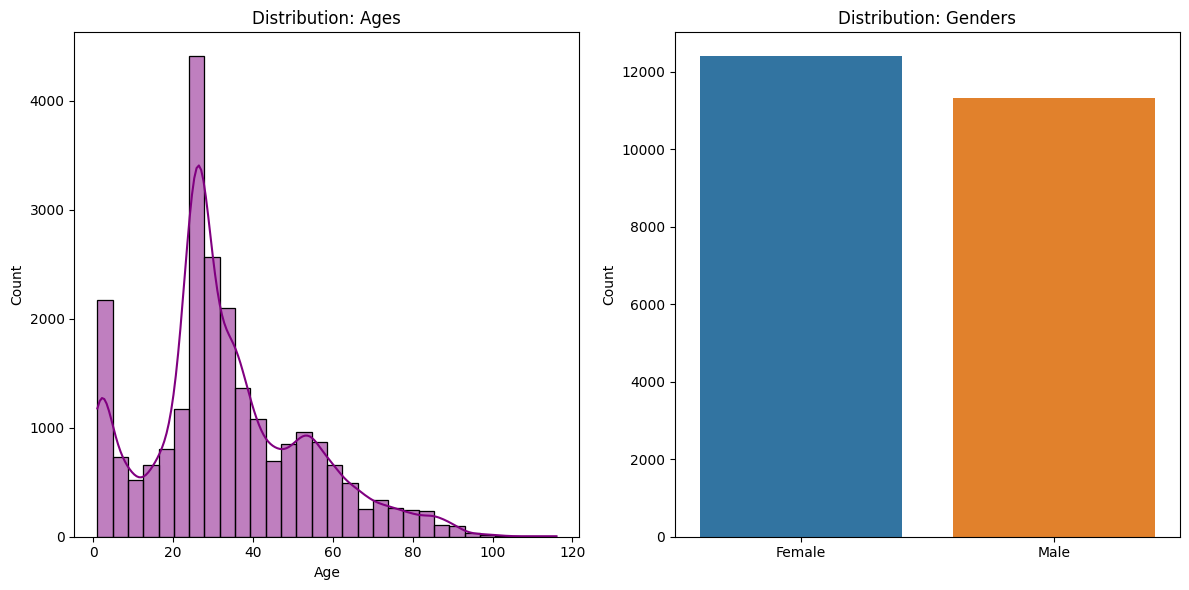

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(cnn_df['Age'], bins=30, kde=True, color='purple')
plt.title('Distribution: Ages')
plt.xlabel('Age')

plt.subplot(1, 2, 2)
sns.barplot(x=['Female', 'Male'], y=cnn_df['Gender'].value_counts())
plt.title('Distribution: Genders')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### Violin Plot for Age Vs Gender Distribution

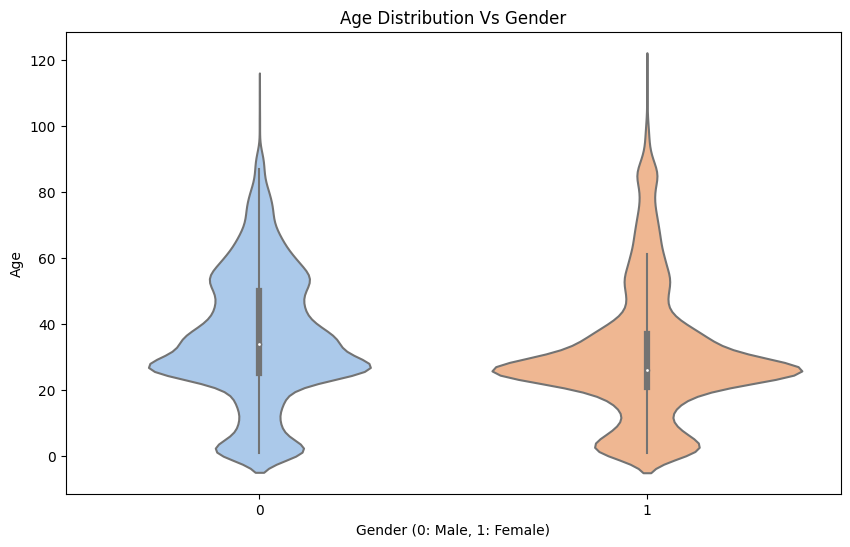

In [29]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Gender', y='Age', data=cnn_df, palette='pastel')
plt.title('Age Distribution Vs Gender')
plt.xlabel('Gender (0: Male, 1: Female)')
plt.ylabel('Age')
plt.show()

## Clustering uisng K Means

In [32]:
imagePath = '3101.jpg'

[7 7 7 ... 6 6 6]


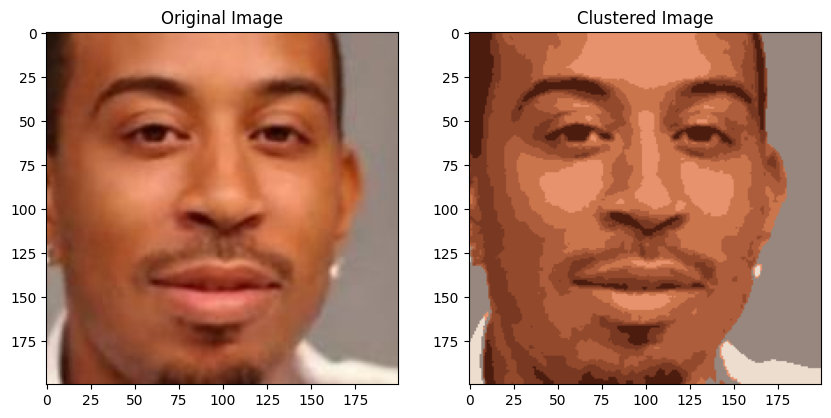

In [33]:
image = cv2.imread(imagePath)
imgColour = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pixelsReshape = imgColour.reshape((-1, 3))

# Perform k-means clustering
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(pixelsReshape)

labels = kmeans.labels_
clusterCenters = kmeans.cluster_centers_
print(labels)
# Assign each pixel to its corresponding cluster center
clusterImg = clusterCenters[labels].reshape(imgColour.shape)

# Display the original and segmented images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(imgColour)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(clusterImg.astype(np.uint8))
plt.title('Clustered Image')

plt.show()


## Visualising Imageintensity distribution

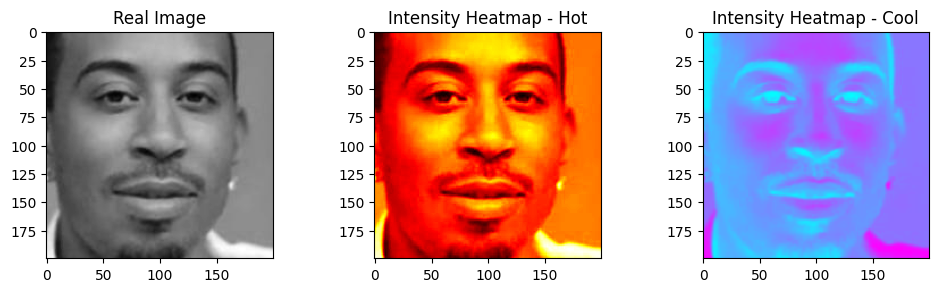

In [34]:
imgGrey = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)

# Display the original image
plt.figure(figsize=(12, 10))
plt.subplot(3, 3, 1)
plt.imshow(imgGrey, cmap='gray')
plt.title('Real Image')

# Display the intensity heatmap
plt.subplot(3, 3, 2)
plt.imshow(imgGrey, cmap='hot', interpolation='nearest')
plt.title('Intensity Heatmap - Hot')

plt.subplot(3, 3, 3)
plt.imshow(imgGrey, cmap='cool', interpolation='nearest')
plt.title('Intensity Heatmap - Cool')


plt.show()


Text(0.5, 1.0, 'Blue Intensity')

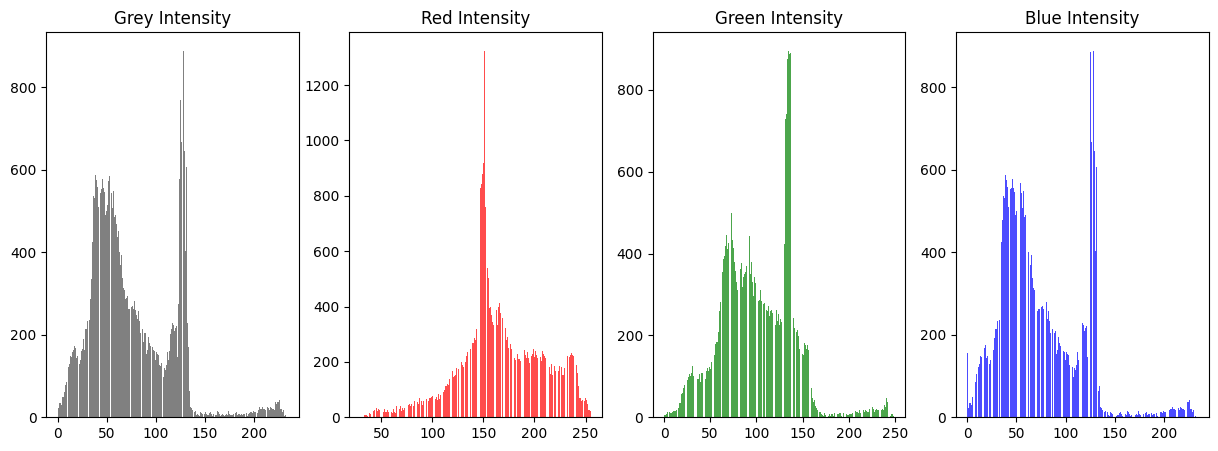

In [35]:
# Spliting the image into three color channels
redChannel = imgColour[:, :, 0]
greenChannel = imgColour[:, :, 1]
blueChannel = imgColour[:, :, 2]

# Plot histograms for each channel
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

axes[0].hist(blueChannel.flatten(), bins=256, color='gray')
axes[0].set_title('Grey Intensity')

axes[1].hist(redChannel.flatten(), bins=256, color='red', alpha=0.7, rwidth=0.8)
axes[1].set_title('Red Intensity')

axes[2].hist(greenChannel.flatten(), bins=256, color='green', alpha=0.7, rwidth=0.8)
axes[2].set_title('Green Intensity')

axes[3].hist(blueChannel.flatten(), bins=256, color='blue', alpha=0.7, rwidth=0.8)
axes[3].set_title('Blue Intensity')


## Defining a Data Generator Function
* This function will extract data from UTKFace images folder

In [36]:
def dataGen(files, batch_size=32):
    while True:
        batchFiles = np.random.choice(files, size=batch_size)
        images = []
        ageVars = []
        genderVars = []

        for bfile in batchFiles:
            image = cv2.imread(os.path.join(filePath, bfile), 0)
            image = cv2.resize(image, dsize=(64, 64))
            image = image.reshape((image.shape[0], image.shape[1], 1))
            images.append(image)

            split_var = bfile.split('_')
            ageVars.append(int(split_var[0]))
            genderVars.append(int(split_var[1]))
        
        #Normalising age, gender and features within the range of 0 and 1
        targetAge = np.array(ageVars, dtype='float32') / 100.0
        targetGender = np.array(genderVars, dtype='float32') / 1.0
        features = np.array(images, dtype='float32') / 255.0

        yield features, [targetAge, targetGender]

In [37]:
print(files[:10])

['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg', '100_1_0_20170112213001988.jpg.chip.jpg', '100_1_0_20170112213303693.jpg.chip.jpg', '100_1_0_20170112215032192.jpg.chip.jpg', '100_1_0_20170117195420803.jpg.chip.jpg', '100_1_0_20170119212053665.jpg.chip.jpg', '100_1_2_20170105174847679.jpg.chip.jpg', '100_1_2_20170112213615815.jpg.chip.jpg']


## Train Test Split

In [38]:
f_train, f_test = train_test_split(files, test_size=0.2, shuffle=True)

## Printing Images in the dataset

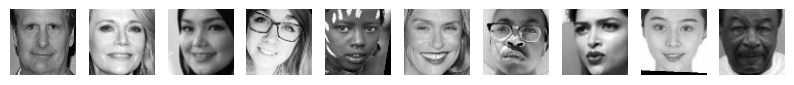

In [39]:
def display_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
    for i in range(len(images)):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.show()


sFiles = np.random.choice(f_train, size=10)
displayImages = []
for file in sFiles:
    image = cv2.imread(os.path.join(filePath, file), 0)
    image = cv2.resize(image, dsize=(64, 64))
    displayImages.append(image.reshape((64, 64, 1)) / 255.0)

display_images(displayImages)

## Defining Models

### Defining CNN Model

In [40]:
inputs = Input(shape=(64, 64, 1))

In [41]:
#inputs = Input(shape=(64, 64, 1))
c1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
c2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(c1)
p1 = MaxPooling2D(pool_size=(2, 2))(c2)
c3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(p1)
p2 = MaxPooling2D(pool_size=(2, 2))(c3)
x = Dropout(0.25)(p2)
flat = Flatten()(x)

### Defining Age Model

In [42]:
ageModel = Dense(128, activation='relu')(flat)
ageModel = Dropout(0.5)(ageModel)
ageModel = Dense(64, activation='relu')(ageModel)
ageModel = Dropout(0.5)(ageModel)
ageModel = Dense(32, activation='relu')(ageModel)
ageModel = Dropout(0.5)(ageModel)
ageModel = Dense(16, activation='relu')(ageModel)
ageModel = Dropout(0.5)(ageModel)
ageModel = Dense(8, activation='relu')(ageModel)
ageModel = Dropout(0.5)(ageModel)
age_output = Dense(1, activation='linear', name='age_output')(ageModel)

### Defining Gender Model

In [43]:
genderModel = Dense(128, activation='relu')(flat)
genderModel = Dropout(0.5)(genderModel)
genderModel = Dense(64, activation='relu')(genderModel)
genderModel = Dropout(0.5)(genderModel)
genderModel = Dense(32, activation='relu')(genderModel)
genderModel = Dropout(0.5)(genderModel)
genderModel = Dense(16, activation='relu')(genderModel)
genderModel = Dropout(0.5)(genderModel)
genderModel = Dense(8, activation='relu')(genderModel)
genderModel = Dropout(0.5)(genderModel)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(genderModel)

## Combining Models and Compiling Final Model

In [44]:
model = Model(inputs=inputs, outputs=[age_output, gender_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'},
              metrics={'age_output': 'mae', 'gender_output': 'accuracy'})

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 62, 62, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 60, 60, 64)   18496       ['conv2d_3[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 30, 30, 64)  0           ['conv2d_4[0][0]']               
                                                                                            

### Creating Data Generators

In [45]:
batchSize = 32
trainGen = dataGen(f_train, batch_size=batchSize)
testGen = dataGen(f_test, batch_size=batchSize)

### Training the Model

In [46]:
stepsEpoch = len(f_train) // batchSize
validationSteps = len(f_test) // batchSize

h = model.fit_generator(trainGen, steps_per_epoch=stepsEpoch,
                        validation_data=testGen, validation_steps=validationSteps,
                        epochs=50)

Epoch 1/50


C:\Users\samar\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


592/592 [==============================] - 27s 44ms/step - loss: 0.7431 - age_output_loss: 0.0536 - gender_output_loss: 0.6896 - age_output_mae: 0.1762 - gender_output_accuracy: 0.5423 - val_loss: 0.7072 - val_age_output_loss: 0.0403 - val_gender_output_loss: 0.6669 - val_age_output_mae: 0.1517 - val_gender_output_accuracy: 0.6666
Epoch 2/50
592/592 [==============================] - 20s 34ms/step - loss: 0.6567 - age_output_loss: 0.0399 - gender_output_loss: 0.6167 - age_output_mae: 0.1528 - gender_output_accuracy: 0.6832 - val_loss: 0.5500 - val_age_output_loss: 0.0402 - val_gender_output_loss: 0.5098 - val_age_output_mae: 0.1538 - val_gender_output_accuracy: 0.7950
Epoch 3/50
592/592 [==============================] - 18s 31ms/step - loss: 0.5684 - age_output_loss: 0.0384 - gender_output_loss: 0.5300 - age_output_mae: 0.1506 - gender_output_accuracy: 0.7627 - val_loss: 0.4746 - val_age_output_loss: 0.0385 - val_gender_output_loss: 0.4361 - val_age_output_mae: 0.1493 - val_gender_out

Epoch 25/50
592/592 [==============================] - 15s 26ms/step - loss: 0.3524 - age_output_loss: 0.0289 - gender_output_loss: 0.3235 - age_output_mae: 0.1257 - gender_output_accuracy: 0.8698 - val_loss: 0.3455 - val_age_output_loss: 0.0318 - val_gender_output_loss: 0.3137 - val_age_output_mae: 0.1328 - val_gender_output_accuracy: 0.8640
Epoch 26/50
592/592 [==============================] - 15s 25ms/step - loss: 0.3325 - age_output_loss: 0.0289 - gender_output_loss: 0.3036 - age_output_mae: 0.1261 - gender_output_accuracy: 0.8813 - val_loss: 0.3096 - val_age_output_loss: 0.0330 - val_gender_output_loss: 0.2767 - val_age_output_mae: 0.1357 - val_gender_output_accuracy: 0.8963
Epoch 27/50
592/592 [==============================] - 15s 26ms/step - loss: 0.3366 - age_output_loss: 0.0277 - gender_output_loss: 0.3089 - age_output_mae: 0.1229 - gender_output_accuracy: 0.8838 - val_loss: 0.3306 - val_age_output_loss: 0.0345 - val_gender_output_loss: 0.2961 - val_age_output_mae: 0.1381 - 

Epoch 49/50
592/592 [==============================] - 16s 26ms/step - loss: 0.2826 - age_output_loss: 0.0255 - gender_output_loss: 0.2571 - age_output_mae: 0.1178 - gender_output_accuracy: 0.9052 - val_loss: 0.3624 - val_age_output_loss: 0.0336 - val_gender_output_loss: 0.3288 - val_age_output_mae: 0.1364 - val_gender_output_accuracy: 0.8866
Epoch 50/50
592/592 [==============================] - 15s 26ms/step - loss: 0.2756 - age_output_loss: 0.0267 - gender_output_loss: 0.2489 - age_output_mae: 0.1209 - gender_output_accuracy: 0.9065 - val_loss: 0.3271 - val_age_output_loss: 0.0299 - val_gender_output_loss: 0.2972 - val_age_output_mae: 0.1286 - val_gender_output_accuracy: 0.8917


### Printing Results

* Gender Accuracy
* Age Model Mean Absolute Error

In [47]:
# Evaluate the model on the test set
evaluationResults = model.evaluate_generator(testGen, steps=len(f_test) // batchSize)

# Extract the accuracy for the gender output
genderAccuracy = evaluationResults[model.metrics_names.index('gender_output_accuracy')]

# Extract the mean absolute error for the age output
ageMAE = evaluationResults[model.metrics_names.index('age_output_mae')]

print("Gender Model Accuracy:", genderAccuracy)
print("Age Model Mean Absolute Error:", ageMAE)

C:\Users\samar\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Gender Model Accuracy: 0.8851351141929626
Age Model Mean Absolute Error: 0.12831860780715942


### Visualizating Model Performance

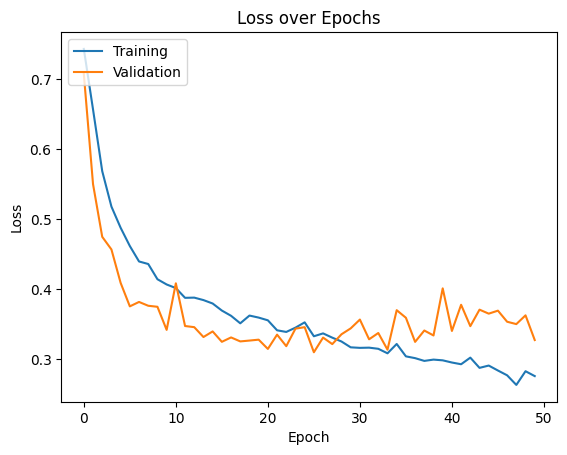

In [63]:
history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Converting to H5 Format

In [60]:
model.save('Cnn_Model.h5')

## Testing the Model on New Image

In [61]:
model_path = 'Cnn_Model.h5'
model = load_model(model_path, compile=False)

# Load and preprocess the new image
new_image_path = '3101.jpg'  # Replace with the path to your new image
new_image = cv2.imread(new_image_path, cv2.IMREAD_GRAYSCALE)
new_image = cv2.resize(new_image, (64, 64))
new_image = new_image.reshape((1, 64, 64, 1)) / 255.0  # Normalize to [0,1]

# Predict age and gender
predictions = model.predict(new_image)
predictedAge = predictions[0][0] * 100.0  # Rescale age prediction
predictedGender = "Male" if predictions[1][0] < 0.5 else "Female"

# Print the predictions
print("Predicted Age:", predictedAge.astype(int))
print("Predicted Gender:", predictedGender)

1/1 [==============================] - 0s 110ms/step
Predicted Age: [29]
Predicted Gender: Male
